In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import mlneuro as mln
import numpy as np
import matplotlib.pyplot as plt
import sklearn as skl


Using TensorFlow backend.


## Options

In [2]:
# Temporal resolution to filter at, in seconds
RESOLUTION = 0.05               
# Number of stimulus bins per dimension
STIMULUS_BINS = 24
# Number of cross-validation folds
N_FOLDS = 3

# Loading data

An example restaurant row dataset (one of Brandy's days) is stored in the package for example generation. We'll use a couple of the visualization functions provided to get a feel for what the raw data looks like

In [3]:
data = mln.datasets.load_restaurant_row()

In [4]:
def shape_of_data(data_item):
    if isinstance(data_item, list):
        return len(data_item), [a.shape for a in data_item]
    elif isinstance(data_item, np.ndarray):
        return 1, data_item.shape
    else:
        return None, None
        
for k in data.keys():
    print('{}:\n\tlength={}\n\tshape of arrays={}\n\n'.format(k, *shape_of_data(data[k])))

signal_times:
	length=21
	shape of arrays=[(5928,), (197977,), (274166,), (137225,), (68692,), (611581,), (116013,), (90690,), (221235,), (1310948,), (323607,), (539304,), (592027,), (184479,), (125327,), (556578,), (315079,), (410771,), (58139,), (914706,), (154644,)]


signal_stimulus:
	length=21
	shape of arrays=[(5928, 2), (197977, 2), (274166, 2), (137225, 2), (68692, 2), (611581, 2), (116013, 2), (90690, 2), (221235, 2), (1310948, 2), (323607, 2), (539304, 2), (592027, 2), (184479, 2), (125327, 2), (556578, 2), (315079, 2), (410771, 2), (58139, 2), (914706, 2), (154644, 2)]


signal_marks:
	length=21
	shape of arrays=[(5928, 12), (197977, 12), (274166, 12), (137225, 12), (68692, 12), (611581, 12), (116013, 12), (90690, 12), (221235, 12), (1310948, 12), (323607, 12), (539304, 12), (592027, 12), (184479, 12), (125327, 12), (556578, 12), (315079, 12), (410771, 12), (58139, 12), (914706, 12), (154644, 12)]


full_stimulus:
	length=1
	shape of arrays=(105496, 2)


full_stimulus_times:

<IPython.core.display.Javascript object>


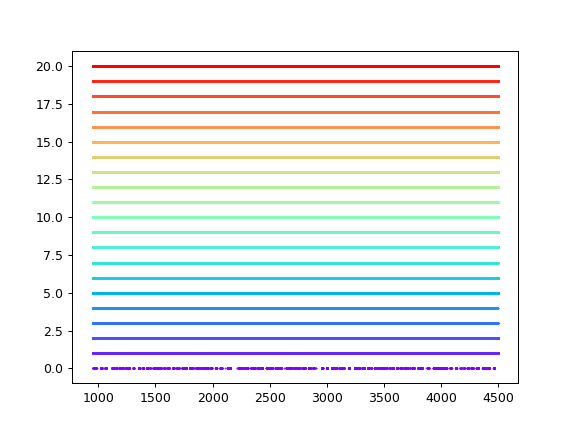

In [5]:
fig = mln.utils.visuals.plot_spike_train(data['signal_times'])

<IPython.core.display.Javascript object>


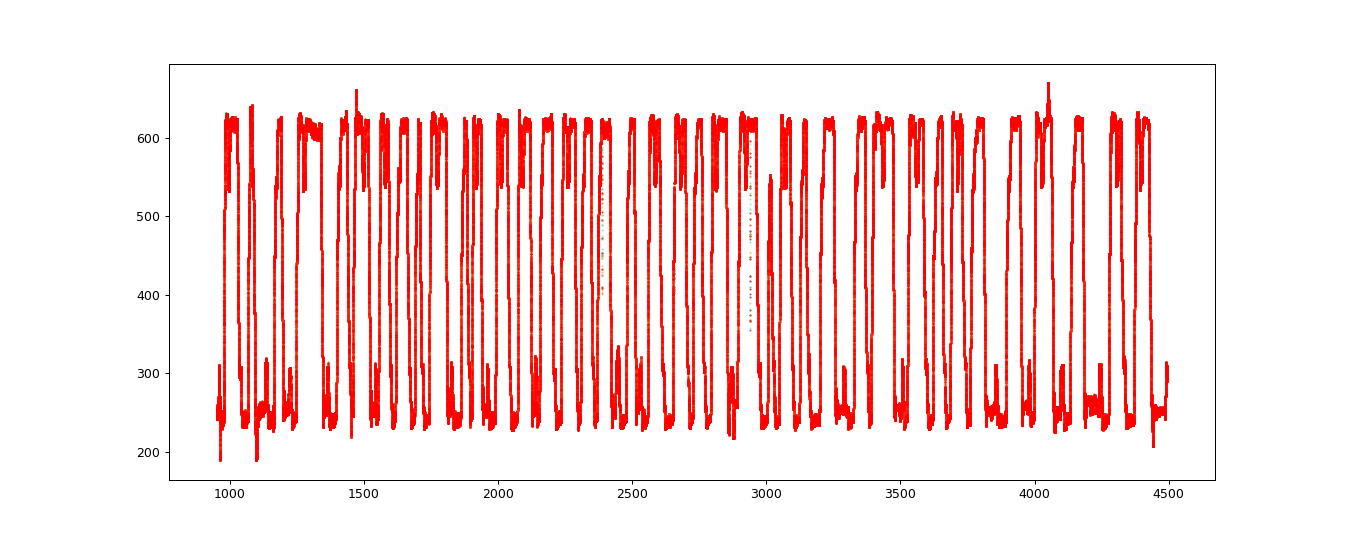

In [6]:
fig = mln.utils.visuals.plot_signal_stimulus(data['signal_times'], data['signal_stimulus'], figsize=(15,6))

<IPython.core.display.Javascript object>


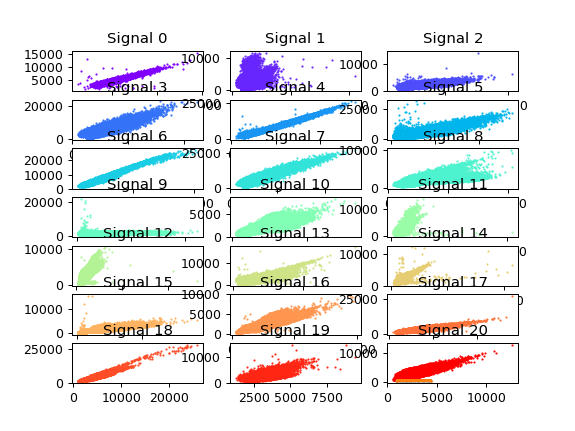

In [7]:
fig, axes = mln.utils.visuals.plot_signal_features(data['signal_marks'], dims=(1,3), max_horizontal=3)

# Data preprocessing

### Removing camera jitter

In [8]:
# Clean up stimulus data to remove jitter from camera
stimulus_times = data['full_stimulus_times']
stimulus_data = data['full_stimulus']
stimulus_data = mln.preprocessing.stimulus.smooth_stimulus(stimulus_times, stimulus_data)

plt.plot(data['full_stimulus_times'], data['full_stimulus'][:, 0])
plt.plot(stimulus_times, stimulus_data[:, 0])

In [9]:
# Assign variables, get the stimulus data at the spike times from the smoothed data
Ts = data['signal_times']
Xs = data['signal_marks']
ys = mln.preprocessing.signals.spike_stimulus(Ts, stimulus_times, stimulus_data)

### Removing noise spikes

In [10]:
# Remove bad spikes, (_ is skipping the cellids data)
Ts, signal_cellids, (Xs, ys) = mln.preprocessing.signals.remove_unlabeled_spikes(Ts, data['signal_cellids'], Xs, ys)

<IPython.core.display.Javascript object>


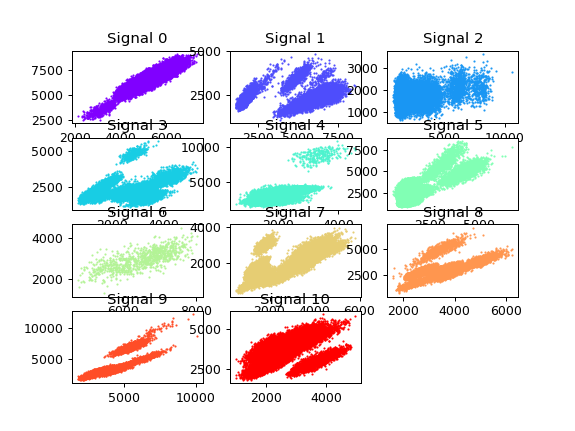

In [11]:
fig, axes = mln.utils.visuals.plot_signal_features(Xs, dims=(1,3), max_horizontal=3)

### Reducing to a single signal

In [12]:
# Separate signal features
# Note, this function will scale the data by default before adding the constant
Xs = mln.preprocessing.signals.separate_signal_features(Xs)

INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 1/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 2/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 3/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 4/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 5/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 6/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 7/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 8/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 9/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 10/11 with data size
INFO:mlneuro.multisignal.meta:Fitting and transforming on signal 11/11 with data size


<IPython.core.display.Javascript object>


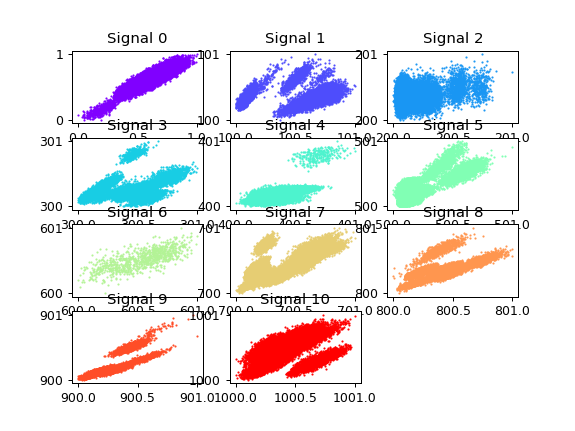

In [13]:
fig, axes = mln.utils.visuals.plot_signal_features(Xs, dims=(1,3), max_horizontal=3)

In [14]:
# Drop to a single signal
T, (X, y) = mln.multisignal.multi_to_single_signal(Ts, Xs, ys)

<IPython.core.display.Javascript object>


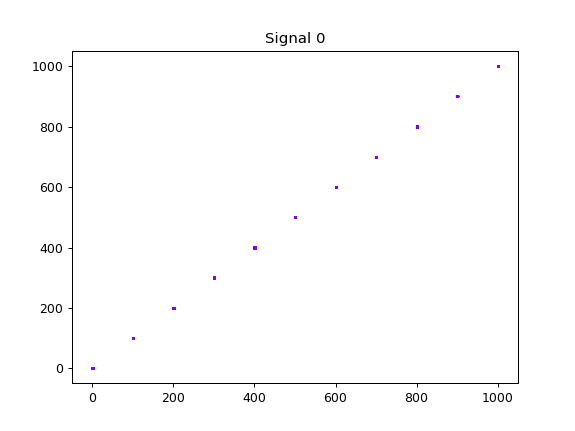

In [15]:
fig, axes = mln.utils.visuals.plot_signal_features(X, dims=(1,3), max_horizontal=3)

### Data splitting

<IPython.core.display.Javascript object>


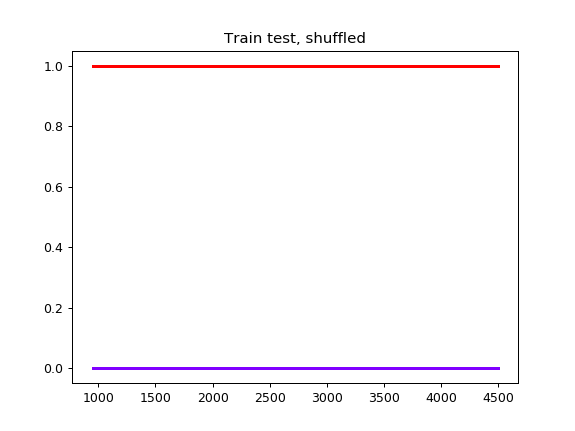

In [16]:
# Split the data into non-overlapping sets
X_train, X_test, T_train, T_test, y_train, y_test = skl.model_selection.train_test_split(X, T, y, test_size=0.25)

fig = mln.utils.visuals.plot_spike_train([T_train, T_test])
plt.title('Train test, shuffled');

<IPython.core.display.Javascript object>


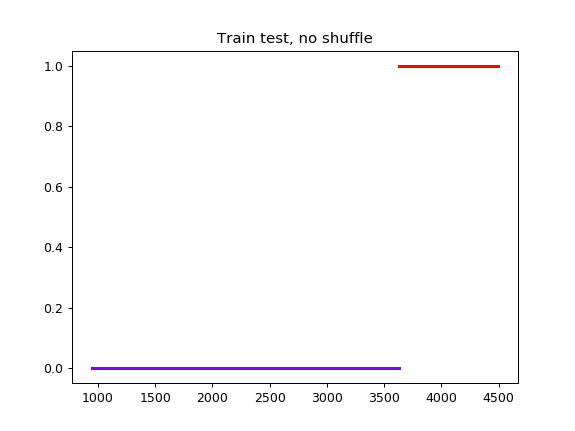

In [17]:
# Split the data into non-overlapping sets without shuffling
X_train, X_test, T_train, T_test, y_train, y_test = skl.model_selection.train_test_split(X, T, y, test_size=0.25, shuffle=False)
fig = mln.utils.visuals.plot_spike_train([T_train, T_test])
plt.title('Train test, no shuffle');

### Get data when the rat is running

/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1775: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1775: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1776: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1776: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1777: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1777: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1783:

<IPython.core.display.Javascript object>


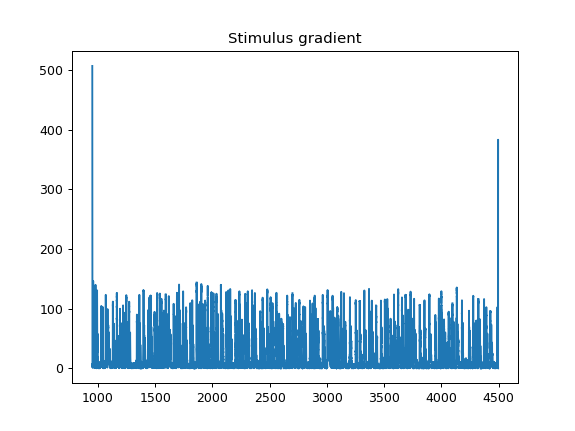

In [18]:
y_gradient = mln.preprocessing.stimulus.stimulus_gradient(T, y)
plt.figure()
plt.plot(T, y_gradient)
plt.title('Stimulus gradient');

<IPython.core.display.Javascript object>


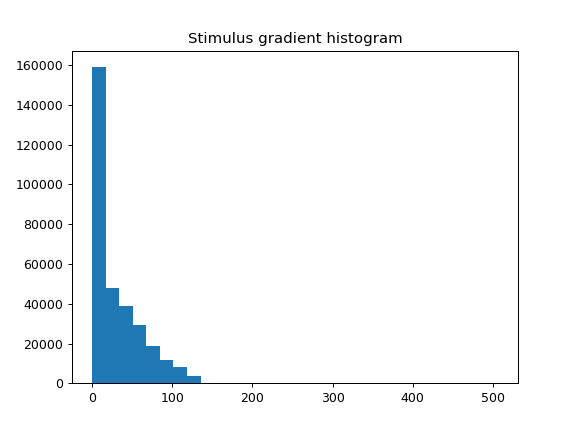

In [19]:
plt.figure()
plt.hist(y_gradient[~np.isnan(y_gradient)], bins=30)
plt.title('Stimulus gradient histogram');

In [20]:
# Create a mask for the training subset when the stimulus is moving quickly (running)
y_train_mask = mln.preprocessing.stimulus.stimulus_gradient_mask(T, y, min_g=5, max_g=400)

/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1775: RuntimeWarning: divide by zero encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1775: RuntimeWarning: invalid value encountered in true_divide
  a = -(dx2)/(dx1 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1776: RuntimeWarning: divide by zero encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1776: RuntimeWarning: invalid value encountered in true_divide
  b = (dx2 - dx1) / (dx1 * dx2)
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1777: RuntimeWarning: divide by zero encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1777: RuntimeWarning: invalid value encountered in true_divide
  c = dx1 / (dx2 * (dx1 + dx2))
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:1783:

### Bin calculation

<IPython.core.display.Javascript object>


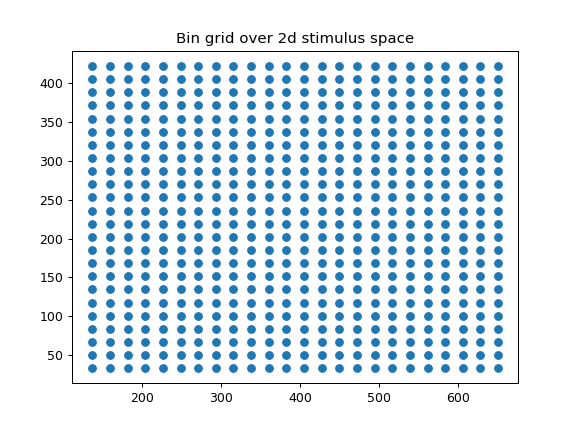

In [21]:
# Calculate bin edges independent of signal data
ybin_edges, ybin_counts = mln.common.bins.bin_edges_from_data(stimulus_data, STIMULUS_BINS)
ybin_grid = mln.common.bins.linearized_bin_grid(mln.common.bins.bin_centers_from_edges(ybin_edges))
plt.figure()
plt.scatter(ybin_grid[:, 0], ybin_grid[:, 1])
plt.title('Bin grid over 2d stimulus space');

In [22]:
[print('list length: {}; data shape: {}'.format(*shape_of_data(d))) for d in [ybin_edges, ybin_grid]];

list length: 2; data shape: [(25,), (25,)]
list length: 1; data shape: (576, 2)


### Firing rate calculation

In [23]:
T_fr, X_fr = mln.preprocessing.signals.process_clustered_signal_data(data['signal_times'], data['signal_cellids'],
                                    temporal_bin_size=RESOLUTION,
                                    bins_before=2,
                                    bins_after=2,
                                    flatten_history=True)

y_fr = mln.preprocessing.stimulus.stimulus_at_times(stimulus_times, stimulus_data, T_fr)


# Estimation

## Building an estimator

In [24]:
# Construct the KDE
kde = mln.regression.BivariateKernelDensity(n_neighbors=30,
                                            bandwidth_X=0.13,
                                            bandwidth_y=12, 
                                            ybins=ybin_edges,
                                            logger_level='debug')


# Construct a pipeline
from sklearn.pipeline import make_pipeline
nn_pipeline = make_pipeline(skl.preprocessing.StandardScaler(), 
                                         mln.regression.DenseNNRegressor(verbose=1))

## Clusterless decoding

### Fit

In [25]:
kde.fit(X_train, y_train);

DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Selected tree backend ball
DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Calculating y densities over 576 bins for 241068 points
DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Fitting nearest neighbor tree of type ball


<IPython.core.display.Javascript object>


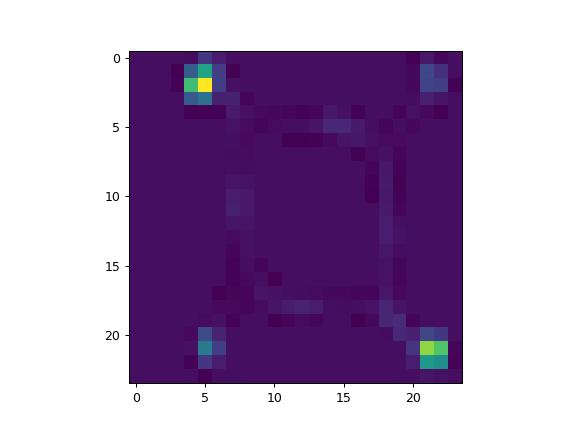

In [26]:
plt.figure()
plt.imshow(np.exp(kde.y_log_occupancy).reshape(STIMULUS_BINS, STIMULUS_BINS))

### Shrink test set

In [27]:
FIRST_N = 10000
X_test = X_test[:FIRST_N, :]
T_test = T_test[:FIRST_N]
y_test = y_test[:FIRST_N, :]

### Predict without filtering

In [28]:
y_pred = kde.predict(X_test)

DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Finding nearest 30 neighbors for 10000 query points in training data size 241068 with dualtree=False
DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Calculating bivariate density over 576 bins for 10000 points


<IPython.core.display.Javascript object>


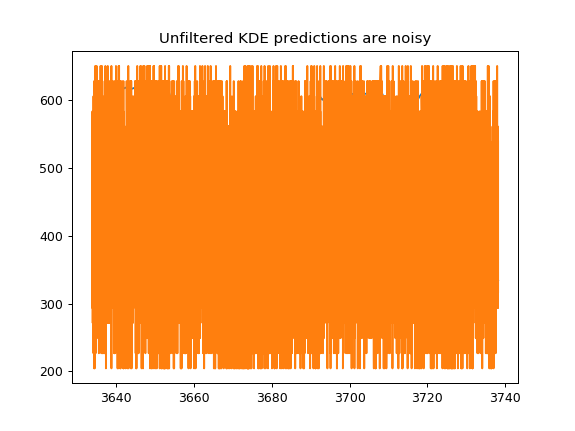

In [29]:
plt.figure()
plt.plot(T_test, y_test[:, 0])
plt.plot(T_test, y_pred[:, 0])
plt.title('Unfiltered KDE predictions are noisy');

### Predict_proba with filtering

In [30]:
y_pred = kde.predict_proba(X_test)

DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Finding nearest 30 neighbors for 10000 query points in training data size 241068 with dualtree=False
DEBUG:mlneuro.regression.kde.BivariateKernelDensity:Calculating bivariate density over 576 bins for 10000 points


#### Example decoded probability

<IPython.core.display.Javascript object>


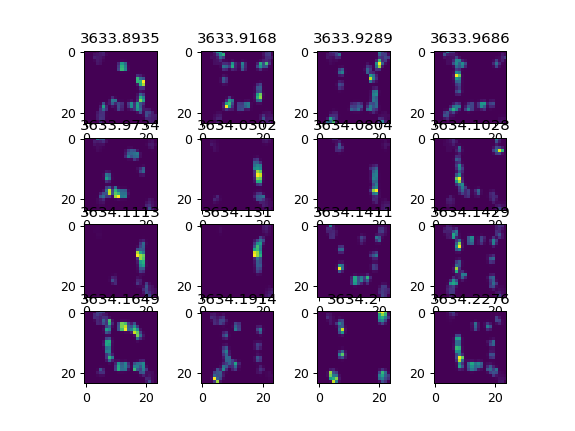

In [31]:
SHOW_N = 16
GAP = 2
fig, axes = mln.utils.visuals.n_subplot_grid(SHOW_N);
for i, ax in enumerate(axes):
    ax.imshow(y_pred[i * GAP,:].reshape(STIMULUS_BINS, STIMULUS_BINS));
    ax.set_title(T_test[i * GAP])

#### Filtered predictions (via argmax)

In [32]:
filt = mln.filtering.TemporalSmoothedFilter(bandwidth_T=2.5*RESOLUTION, std_deviation=5, n_jobs=1)
T_pred, (y_pred, y_test) =  mln.filtering.filter_at(filt, RESOLUTION, T_test, y_pred, y_test)

# Normalize to a probability distribution since the smoothing may have disrupted it
y_pred /= np.sum(y_pred, axis=1)[:, np.newaxis]

# Calculate the max-predicted bin
y_predicted = ybin_grid[np.argmax(y_pred, axis=1)]

<IPython.core.display.Javascript object>


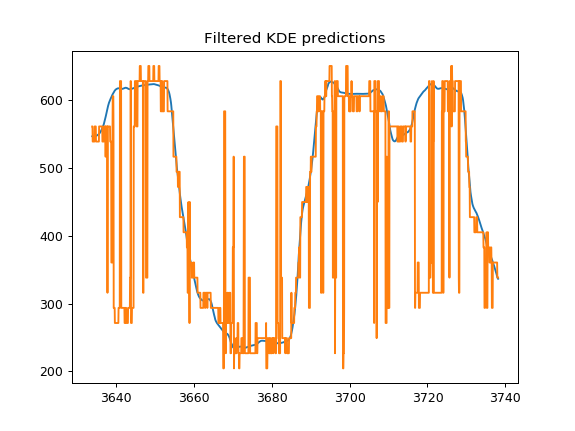

In [33]:
plt.figure()
plt.plot(T_pred, y_test[:,0])
plt.plot(T_pred, y_predicted[:,0])
plt.title('Filtered KDE predictions');

## Clustered decoding

In [34]:
# Split the data into non-overlapping sets
X_train, X_test, T_train, T_test, y_train, y_test = skl.model_selection.train_test_split(X_fr, T_fr, y_fr, test_size=0.1, shuffle=False)

nn_pipeline.fit(X_train, y_train)
y_pred = nn_pipeline.predict(X_test)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Epoch 1/20
63806/63806 [==============================] - 3s - loss: 15156.3325 - acc: 0.9040     
Epoch 2/20
63806/63806 [==============================] - 3s - loss: 9506.7452 - acc: 0.9317     
Epoch 3/20
63806/63806 [==============================] - 3s - loss: 8398.4178 - acc: 0.9396     
Epoch 4/20
63806/63806 [==============================] - 3s - loss: 7679.9801 - acc: 0.9422     
Epoch 5/20
63806/63806 [==============================] - 7s - loss: 7156.8893 - acc: 0.9452     
Epoch 6/20
63806/63806 [==============================] - 9s - loss: 6750.3514 - acc: 0.9469     
Epoch 7/20
63806/63806 [==============================] - 15s - loss: 6381.5478 - acc: 0.9485    
Epoch 8/20
63806/63806 [==============================] - 8s - loss: 6043.6033 - acc: 0.9515     
Epoch 9/20
63806/63806 [==============================] - 3s - loss: 

<IPython.core.display.Javascript object>


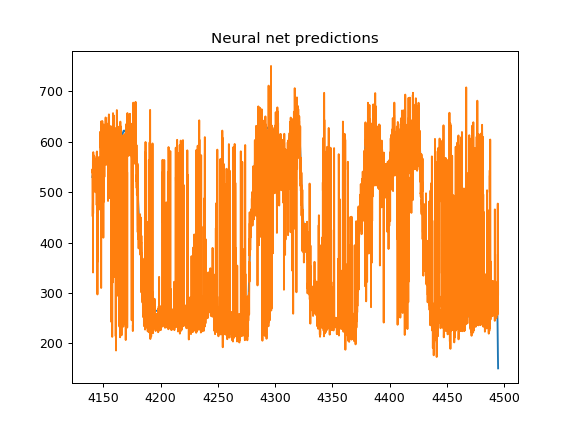

In [35]:
plt.figure()
plt.plot(T_test, y_test[:, 0])
plt.plot(T_test, y_pred[:, 0])
plt.title('Neural net predictions');

<IPython.core.display.Javascript object>


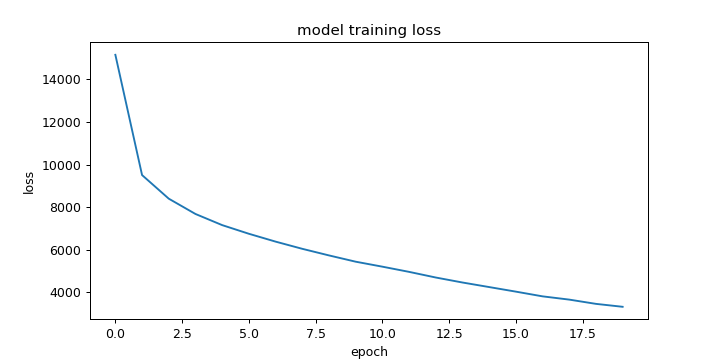

In [36]:
nn = nn_pipeline.steps[-1][1]
plt.figure(figsize=(8,4))
plt.plot(nn.model.model.history.history['loss'])
plt.title('model training loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

### Overfitting

In [37]:
nn_pipeline = make_pipeline(skl.preprocessing.StandardScaler(), 
                                         mln.regression.DenseNNBinnedRegressor(dropout=0, verbose=1))

nn_pipeline.fit(X_train, y_train, densennbinnedregressor__validation_split=0.15)
y_pred = nn_pipeline.predict_proba(X_test)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 54235 samples, validate on 9571 samples
Epoch 1/20
54235/54235 [==============================] - 7s - loss: 13457.3107 - categorical_accuracy: 0.3941 - val_loss: 12421.0036 - val_categorical_accuracy: 0.4108
Epoch 2/20
54235/54235 [==============================] - 6s - loss: 10036.3597 - categorical_accuracy: 0.5000 - val_loss: 12143.0962 - val_categorical_accuracy: 0.4337
Epoch 3/20
54235/54235 [==============================] - 6s - loss: 9354.9137 - categorical_accuracy: 0.5319 - val_loss: 11886.4391 - val_categorical_accuracy: 0.4298
Epoch 4/20
54235/54235 [==============================] - 6s - loss: 8922.2740 - categorical_accuracy: 0.5576 - val_loss: 11741.6854 - val_categorical_accuracy: 0.4401
Epoch 5/20
54235/54235 [==============================] - 7s - loss: 8569.7010 - categorical_accuracy: 0.5741 - val_loss: 12168.062

#### Example decoded probability

<IPython.core.display.Javascript object>


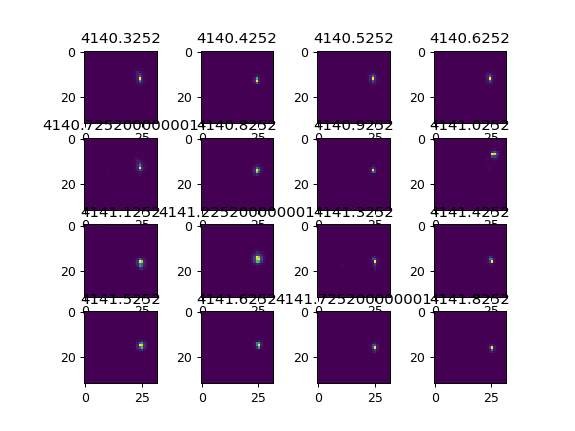

In [38]:
SHOW_N = 16
GAP = 2
fig, axes = mln.utils.visuals.n_subplot_grid(SHOW_N);
for i, ax in enumerate(axes):
    ax.imshow(y_pred[i * GAP,:].reshape(32, 32));
    ax.set_title(T_test[i * GAP])

#### Overfitting neural network results

In [39]:
# plt.figure()
# plt.plot(T_test, y_test[:, 0])
# plt.plot(T_test, y_pred[:, 0])
# plt.title('Neural net predictions');

<IPython.core.display.Javascript object>


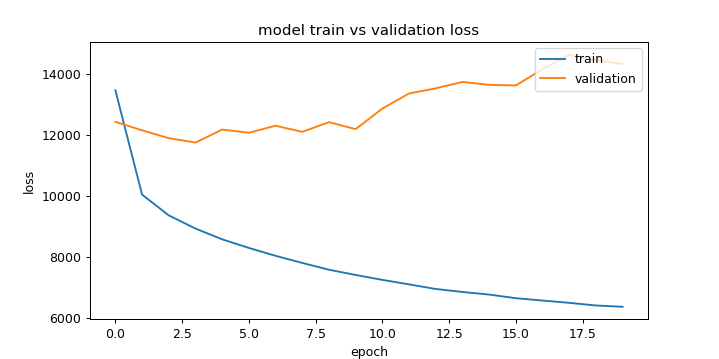

In [40]:
nn = nn_pipeline.steps[-1][1]
plt.figure(figsize=(8,4))
plt.plot(nn.model.model.history.history['loss'])
plt.plot(nn.model.model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

#### Adding dropout

In [41]:
nn_pipeline = make_pipeline(skl.preprocessing.StandardScaler(), 
                                         mln.regression.DenseNNBinnedRegressor(dropout=0.4, verbose=1))

nn_pipeline.fit(X_train, y_train, densennbinnedregressor__validation_split=0.15)
y_pred = nn_pipeline.predict(X_test)

Train on 54235 samples, validate on 9571 samples
Epoch 1/20
54235/54235 [==============================] - 8s - loss: 19832.0576 - categorical_accuracy: 0.2326 - val_loss: 17009.8967 - val_categorical_accuracy: 0.2588
Epoch 2/20
54235/54235 [==============================] - 8s - loss: 15803.0580 - categorical_accuracy: 0.3034 - val_loss: 15205.5505 - val_categorical_accuracy: 0.2875
Epoch 3/20
54235/54235 [==============================] - 7s - loss: 14411.7541 - categorical_accuracy: 0.3334 - val_loss: 14012.2318 - val_categorical_accuracy: 0.3223
Epoch 4/20
54235/54235 [==============================] - 7s - loss: 13669.4923 - categorical_accuracy: 0.3560 - val_loss: 13665.9809 - val_categorical_accuracy: 0.3506
Epoch 5/20
54235/54235 [==============================] - 8s - loss: 13215.7134 - categorical_accuracy: 0.3686 - val_loss: 13452.5413 - val_categorical_accuracy: 0.3529
Epoch 6/20
54235/54235 [==============================] - 8s - loss: 12977.7617 - categorical_accuracy: 0.

<IPython.core.display.Javascript object>


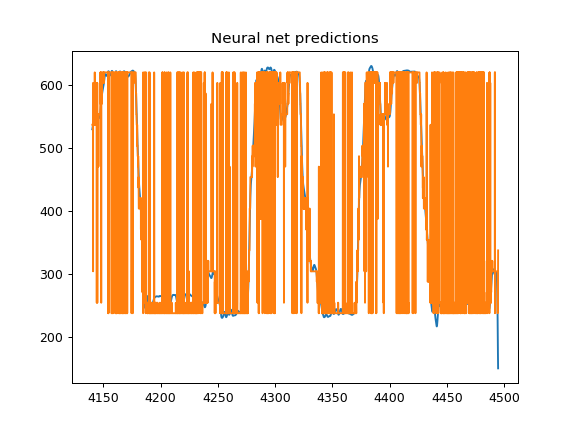

In [42]:
plt.figure()
plt.plot(T_test, y_test[:, 0])
plt.plot(T_test, y_pred[:, 0])
plt.title('Neural net predictions');

/usr/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


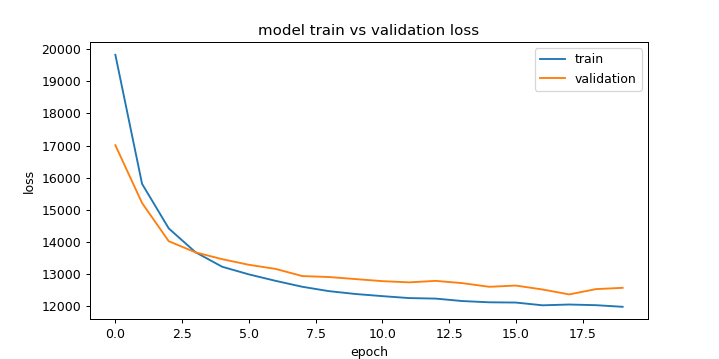

In [43]:
nn = nn_pipeline.steps[-1][1]
plt.figure(figsize=(8,4))
plt.plot(nn.model.model.history.history['loss'])
plt.plot(nn.model.model.history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()